# Extracting keywords from papers


Journal-provided Keywords are too broad to be useful.  
I will extract keywords from the abstract carried along with a bibtex entry.
A few options exist for NLP(Natural Language Processing.) In this notebook, I will use a python module called nltk (Natual Language Toolkit.)  
Note that different functionalities of NLTK depend on different DBs.


A general tutorial on NLTK (https://www.guru99.com/nltk-tutorial.html)  
NLTK syntax processing https://krakensystems.co/blog/2018/nlp-syntax-processing  
A working example of keyword extraction using different tool sets 
https://towardsdatascience.com/textrank-for-keyword-extraction-by-python-c0bae21bcec0

See also great keyword extraction packages such as  
rake-nltk, RAKE (Rapid Automatic Keyword Extraction algorithm) or  
KEA (Keyphrase extraction algorithm)

In [1]:
import bibtexparser

# Abstracts in plain text, or unstrctured text form.
with open("Cluster_env_papers.bib", "r") as f:
    bib_db = bibtexparser.load(f)

In [2]:
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')

## Basic concepts
#### tokenize sentences 

In [4]:
entry = bib_db.entries[2]

In [5]:
tokens = nltk.word_tokenize(entry['abstract'])

#### identify types of words (POS, part of speech)

In [6]:
nltk.pos_tag(tokens)

[('We', 'PRP'),
 ('examine', 'VBP'),
 ('subhaloes', 'NNS'),
 ('and', 'CC'),
 ('galaxies', 'NNS'),
 ('residing', 'VBG'),
 ('in', 'IN'),
 ('a', 'DT'),
 ('simulated', 'JJ'),
 ('LCDM', 'NNP'),
 ('galaxy', 'NN'),
 ('cluster', 'NN'),
 ('(', '('),
 ('{', '('),
 ('\\', 'VB'),
 ('$', '$'),
 ('}', ')'),
 ('M', 'NNP'),
 ('{', '('),
 ('\\^', 'VB'),
 ('{', '('),
 ('}', ')'),
 ('}', ')'),
 ('{', '('),
 ('\\', 'JJ'),
 ('{', '('),
 ('}', ')'),
 ('\\backslashrm', 'NNP'),
 ('crit', 'NN'),
 ('{', '('),
 ('\\', 'JJ'),
 ('}', ')'),
 ('}', ')'),
 ('{', '('),
 ('\\_', 'JJ'),
 ('}', ')'),
 ('{', '('),
 ('\\', 'JJ'),
 ('{', '('),
 ('}', ')'),
 ('200', 'CD'),
 ('{', '('),
 ('\\', 'NN'),
 ('}', ')'),
 ('}', ')'),
 ('=1.1\\backslashtimes10', 'NNP'),
 ('{', '('),
 ('\\^', 'VB'),
 ('{', '('),
 ('}', ')'),
 ('}', ')'),
 ('{', '('),
 ('\\', 'JJ'),
 ('{', '('),
 ('}', ')'),
 ('15', 'CD'),
 ('{', '('),
 ('\\', 'NN'),
 ('}', ')'),
 ('}', ')'),
 ('M', 'NNP'),
 ('{', '('),
 ('\\_', 'VB'),
 ('}', ')'),
 ('\\backslashodot/h

#### stem words 
convert to its *root* form. (solve, solving -> solv)  
Already multiple altorightms are available for stemming.

In [120]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer

porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer('english')

In [31]:
print(porter.stem("treated"))
print(lancaster.stem("treated"))
print(snowball.stem("treated"))

treat
tre
treat


#### Lemmatization 
convert to the *dictionary* form of a word.

In [8]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [39]:
wnl.lemmatize("galaxies")

'galaxy'

In [35]:
wnl.lemmatize("treated")

'treated'

In [36]:
print(porter.stem("subhaloes"))
print(wnl.lemmatize("subhaloes"))

subhalo
subhaloes


In [37]:
print(porter.stem("accreted"))
print(wnl.lemmatize("accreted"))

accret
accreted


In [38]:
print(porter.stem("infalling"))
print(wnl.lemmatize("infalling"))

infal
infalling


As demonstrated, lemmatization depends on dictionary vocavulary. Domain-specific words such as *infall* or *accrete* does not get correct vocab matching. Hmmm.. 

### removing stopwords (prepositions, pronouns, conjunctions, ...)

In [16]:
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
import re
## corpus is a term used in linguistics meaning a large set of text body.
stop_words = set(stopwords.words("english"))

In [114]:
# add some more custom stopwords if you want
stop_words = stop_words.union(["study", "paper", "M", "h", "we"])

In [138]:
corpus = []

for entry in bib_db.entries:
    try:
        text = re.sub('[^a-zA-Z]', ' ', entry["abstract"]) #
        text = text.lower()
        text = re.sub("(\\d|\\W)+"," ",text) # Remove special characters
        text = re.sub("backslash\w*", " ", text) # Remove Latex equation commands
        text = re.sub("\s[a-zA-Z]{1,2}\s", ' ', text) # remove one or two-letter words (units: M, K, s, pc, km, ...)

        text = [wnl.lemmatize(word) for word in text.split() if not word in stop_words]
        text = " ".join(text)
        corpus.append(text)
    except:
        pass

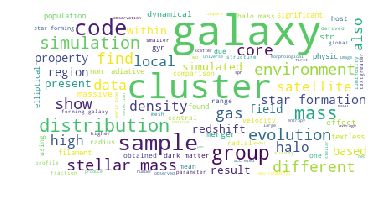

In [139]:
# visualize words
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
#% matplotlib inline
wordcloud = WordCloud(background_color='white',
                      stopwords=stop_words,
                      max_words=100,
                      max_font_size=50, 
                      random_state=42
                     ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

### Now we also consider bi and tri-grams.

In [144]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(max_df=0.8,
                   stop_words=stop_words,
                   max_features=3000,
                   ngram_range=(1,3))
"""
max_df = 0.8  : ignore too general words
ngram_range : search for features of single, two, and three words.
"""
X=cv.fit_transform(corpus)

In [145]:
list(cv.vocabulary_.keys())[:10]

['image',
 'available',
 'http',
 'ab',
 'unprecedented',
 'area',
 'surveyed',
 'subaru',
 'strategic',
 'program']

In [148]:
# Most frequent words
def get_top_n_words(corpus, n=None, ngram=1):
    vec = CountVectorizer(ngram_range=(ngram, ngram),
                          max_features = 2000).fit(corpus)
    bag_of_words = vec.transform(corpus) # bag meaning not caring their order.
    sum_words = bag_of_words.sum(axis=0) # why?
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x : x[1], reverse=True)
    return words_freq[:n]


In [153]:
get_top_n_words(corpus, n=20, ngram=2)

[('galaxy cluster', 16),
 ('stellar mass', 15),
 ('star formation', 11),
 ('cluster galaxy', 9),
 ('non radiative', 8),
 ('dark matter', 7),
 ('halo mass', 7),
 ('star forming', 7),
 ('forming galaxy', 7),
 ('early type', 6),
 ('agn feedback', 5),
 ('large scale', 5),
 ('group cluster', 5),
 ('environmental process', 5),
 ('ram pressure', 5),
 ('particle hydrodynamics', 4),
 ('code code', 4),
 ('dynamical mass', 4),
 ('galaxy galaxy', 4),
 ('massive galaxy', 4)]

# frequent but general Vs. frequent and topic-specific

TF-IDF  
https://en.wikipedia.org/wiki/Tf%E2%80%93idf


from sklearn.feature_extraction.text import TfidfTransformer 